# HW4

In [1]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Web Scraping

# 1. Define the target URL and use a session (so we can attach cookies for logged-in view)
url = "https://hooslist.virginia.edu/1262/Group/DataScience"
session = requests.Session()

response = session.get(url)

# 2. Parse the HTML
soup = BeautifulSoup(response.content, 'html.parser')
# print(f'soup: {soup}')

# 3. Find all section links — data lives in <a> tags with class js-section-link (data-* attributes)
section_links = soup.find_all('a', class_='js-section-link')
print(f'Found {len(section_links)} section links')

# 4. Extract only fields needed for HW4 (4.2 schema + 4.3 queries):
#   - 4.3.1: subject, course name, meeting time, location, instructor
#   - 4.3.2: course name, meeting time, location, professor
#   - 4.3.3/4.3.4: room + meeting time for conflict detection
#   - 4.3.5: enrollment (salary not on Lou's List; add separately)
rows = []
for link in section_links:
    rows.append({
        'class_number': link.get('data-classnumber'),
        'title': link.get('data-title'),
        'instructors': link.get('data-instructors'),
        'subject': link.get('data-subject'),
        'section': link.get('data-sectioncode'),
        'term': link.get('data-term'),
        'meeting_time': link.get('data-meetings'),  # days, start, end
        'location': link.get('data-location'),
        'enrollment': link.get('data-enrollment'),
    })

print(f'rows: {rows}')

# 5. Load into Pandas
df = pd.DataFrame(rows)
# Drop rows where we didn't get a class number (e.g. header or non-section links)
df = df.dropna(subset=['class_number']).reset_index(drop=True)
print(f'Extracted {len(df)} course sections')
print(df[['class_number', 'title', 'instructors', 'subject', 'section', 'meeting_time', 'location', 'enrollment']].head(10))

Found 169 section links
rows: [{'class_number': '15256', 'title': 'Foundation of Data Science', 'instructors': 'Brian Wright', 'subject': 'DS', 'section': '100', 'term': 'Spring 2026', 'meeting_time': '[{"days":"Mo|We","start":"02:00 PM","end":"03:15 PM"}]', 'location': 'N/A', 'enrollment': '153 / 240 '}, {'class_number': '15257', 'title': 'Foundation of Data Science', 'instructors': 'Ali Rivera', 'subject': 'DS', 'section': '101', 'term': 'Spring 2026', 'meeting_time': '[{"days":"Fr","start":"02:00 PM","end":"02:50 PM"}]', 'location': 'N/A', 'enrollment': '40 / 40 '}, {'class_number': '15296', 'title': 'Foundation of Data Science', 'instructors': 'TBD', 'subject': 'DS', 'section': '102', 'term': 'Spring 2026', 'meeting_time': '[{"days":"Fr","start":"12:00 PM","end":"12:50 PM"}]', 'location': 'N/A', 'enrollment': '27 / 40 '}, {'class_number': '15258', 'title': 'Foundation of Data Science', 'instructors': 'Ali Rivera', 'subject': 'DS', 'section': '103', 'term': 'Spring 2026', 'meeting_t

# 4.1

Confidence: 7

![ERD](hw4.drawio.png)

# 4.2 Data Preparation - Physical Level

## 4.2.1

Confidence: 7

In [3]:
import sqlite3
conn = sqlite3.connect('lous_list.db')
conn.execute('PRAGMA foreign_keys = ON')

conn.execute('''
CREATE TABLE IF NOT EXISTS professors (
    professor_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name         TEXT NOT NULL,
    department   TEXT
)
''')
conn.execute('''
CREATE TABLE IF NOT EXISTS rooms (
    room_id   INTEGER PRIMARY KEY AUTOINCREMENT,
    building  TEXT,
    capacity  INTEGER
)
''')
conn.execute('''
CREATE TABLE IF NOT EXISTS classes (
    class_id     INTEGER PRIMARY KEY AUTOINCREMENT,
    course_name  TEXT NOT NULL,
    subject      TEXT NOT NULL,
    meeting_time TEXT,
    professor_id INTEGER,
    room_id      INTEGER,
    FOREIGN KEY (professor_id) REFERENCES professors(professor_id),
    FOREIGN KEY (room_id) REFERENCES rooms(room_id)
)
''')
conn.execute('''
CREATE TABLE IF NOT EXISTS students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name       TEXT NOT NULL,
    major      TEXT
)
''')
conn.execute('''
CREATE TABLE IF NOT EXISTS enrollments (
    enrollment_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id    INTEGER NOT NULL,
    class_id      INTEGER NOT NULL,
    FOREIGN KEY (student_id) REFERENCES students(student_id),
    FOREIGN KEY (class_id) REFERENCES classes(class_id)
)
''')
conn.commit()
conn.close()
print('Schema created: professors, rooms, classes, students, enrollments')

Schema created: professors, rooms, classes, students, enrollments


## 4.2.2

Confidence: 7

In [4]:
import sqlite3
# Ensure scraper cell was run so df exists
assert 'df' in dir(), 'Run the scraper cell first to create df.'

conn = sqlite3.connect('lous_list.db')
conn.execute('PRAGMA foreign_keys = ON')

# Clear so we can re-run this cell (optional: comment out to only append)
conn.execute('DELETE FROM enrollments')
conn.execute('DELETE FROM classes')
conn.execute('DELETE FROM students')
conn.execute('DELETE FROM professors')
conn.execute('DELETE FROM rooms')

# 1. Professors (unique instructors from df) — at least 5
instructors = df['instructors'].dropna().unique().tolist()
instructors = [n for n in instructors if str(n).strip() and n != 'TBD'][:50]
for name in instructors:
    conn.execute('INSERT OR IGNORE INTO professors (name, department) VALUES (?, ?)', (name.strip(), 'Data Science'))
for _ in range(max(0, 5 - len(instructors))):
    conn.execute('INSERT INTO professors (name, department) VALUES (?, ?)', (f'Professor {_}', 'DS'))
name_to_pid = {row[1]: row[0] for row in conn.execute('SELECT professor_id, name FROM professors').fetchall()}

# 2. Rooms — at least 5
for i in range(5):
    conn.execute('INSERT INTO rooms (building, capacity) VALUES (?, ?)', (f'Building {i+1}', 50))
room_ids = [r[0] for r in conn.execute('SELECT room_id FROM rooms').fetchall()]

# 3. Classes — at least 20
classes_inserted = 0
for _, row in df.iterrows():
    if classes_inserted >= 20:
        break
    name = (row['instructors'] or '').strip()
    pid = name_to_pid.get(name) or name_to_pid.get('Professor 0')
    if pid is None:
        continue
    rid = room_ids[classes_inserted % len(room_ids)]
    conn.execute('''INSERT INTO classes (course_name, subject, meeting_time, professor_id, room_id)
                    VALUES (?, ?, ?, ?, ?)''',
                 (row['title'], row['subject'] or 'DS', row.get('meeting_time'), pid, rid))
    classes_inserted += 1
class_ids = [r[0] for r in conn.execute('SELECT class_id FROM classes').fetchall()]

# 4. Students — at least 5 (placeholder; not from Lou's List)
for name in ['Alice Chen', 'Bob Smith', 'Carol Lee', 'Dan Brown', 'Eve Wilson']:
    conn.execute('INSERT INTO students (name, major) VALUES (?, ?)', (name, 'Data Science'))
student_ids = [r[0] for r in conn.execute('SELECT student_id FROM students').fetchall()]

# 5. Enrollments — at least 5
for i in range(5):
    conn.execute('INSERT INTO enrollments (student_id, class_id) VALUES (?, ?)',
                 (student_ids[i % len(student_ids)], class_ids[i % len(class_ids)]))

conn.commit()
conn.close()

# Verify counts
conn = sqlite3.connect('lous_list.db')
for t in ['professors', 'rooms', 'classes', 'students', 'enrollments']:
    n = conn.execute(f'SELECT COUNT(*) FROM {t}').fetchone()[0]
    print(f'{t}: {n} rows')
conn.close()

professors: 50 rows
rooms: 5 rows
classes: 20 rows
students: 5 rows
enrollments: 5 rows


In [5]:
# Check on the schema
conn = sqlite3.connect('lous_list.db')
for row in conn.execute("SELECT name, sql FROM sqlite_master WHERE type = 'table' ORDER BY name"):
    print(row[0])
    print(row[1])
    print()

conn.close()

classes
CREATE TABLE classes (
    class_id     INTEGER PRIMARY KEY AUTOINCREMENT,
    course_name  TEXT NOT NULL,
    subject      TEXT NOT NULL,
    meeting_time TEXT,
    professor_id INTEGER,
    room_id      INTEGER,
    FOREIGN KEY (professor_id) REFERENCES professors(professor_id),
    FOREIGN KEY (room_id) REFERENCES rooms(room_id)
)

enrollments
CREATE TABLE enrollments (
    enrollment_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id    INTEGER NOT NULL,
    class_id      INTEGER NOT NULL,
    FOREIGN KEY (student_id) REFERENCES students(student_id),
    FOREIGN KEY (class_id) REFERENCES classes(class_id)
)

professors
CREATE TABLE professors (
    professor_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name         TEXT NOT NULL,
    department   TEXT
, salary REAL)

rooms
CREATE TABLE rooms (
    room_id   INTEGER PRIMARY KEY AUTOINCREMENT,
    building  TEXT,
    capacity  INTEGER
)

sqlite_sequence
CREATE TABLE sqlite_sequence(name,seq)

students
CREATE TABLE students (
 

# 4.3

## 4.3.1 Student: Finding Classes

Confidence: 8

In [6]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('lous_list.db')
q = """
SELECT
    c.course_name,
    c.meeting_time,
    r.building AS location,
    p.name AS instructor
FROM classes c
LEFT JOIN professors p ON c.professor_id = p.professor_id
LEFT JOIN rooms r ON c.room_id = r.room_id
WHERE c.subject = 'DS'
ORDER BY c.course_name, c.meeting_time
"""
student_search = pd.read_sql_query(q, conn)
conn.close()

display(student_search)

,course_name,meeting_time,location,instructor
0,Analytics I: Foundations of Machine Learning,"[{""days"":""Tu|Th"",""start"":""02:00 PM"",""end"":""03:...",Building 4,Brian Wright
1,Analytics I: Foundations of Machine Learning,"[{""days"":""Tu|Th"",""start"":""03:30 PM"",""end"":""04:...",Building 5,Terence Johnson
2,Communicating with Data,"[{""days"":""Mo|We|Fr"",""start"":""11:00 AM"",""end"":""...",Building 5,Hannah Bako
3,Communicating with Data,"[{""days"":""Tu|Th"",""start"":""09:30 AM"",""end"":""10:...",Building 4,Nur Yildirim
4,Data Ethics,"[{""days"":""Tu|Th"",""start"":""11:00 AM"",""end"":""12:...",Building 1,Emanuel Moss
5,Data Ethics,"[{""days"":""Tu|Th"",""start"":""12:30 PM"",""end"":""01:...",Building 2,David Danks
6,Data Science Systems,"[{""days"":""Mo|We|Fr"",""start"":""09:00 AM"",""end"":""...",Building 1,Jon Tupitza
7,Data Science Systems,"[{""days"":""Mo|We|Fr"",""start"":""09:00 AM"",""end"":""...",Building 3,Karsten Siller
8,Data Science Systems,"[{""days"":""Mo|We|Fr"",""start"":""10:00 AM"",""end"":""...",Building 2,Jason Williamson
9,Foundation of Data Science,"[{""days"":""Fr"",""start"":""01:00 PM"",""end"":""01:50 ...",Building 3,Ali Rivera


## 4.3.2

Confidence: 8

In [7]:
conn = sqlite3.connect('lous_list.db')
q = """
SELECT
    c.course_name,
    c.meeting_time,
    r.building AS location,
    p.name AS instructor
FROM classes c
JOIN professors p ON c.professor_id = p.professor_id
LEFT JOIN rooms r ON c.room_id = r.room_id
WHERE p.name = 'Mai Dahshan'
ORDER BY c.meeting_time, c.course_name
"""
teaching_schedule = pd.read_sql_query(q, conn)
conn.close()

display(teaching_schedule)

,course_name,meeting_time,location,instructor
0,Programming for Data Science,"[{""days"":""Mo|We"",""start"":""03:30 PM"",""end"":""04:...",Building 4,Mai Dahshan
1,Programming for Data Science,"[{""days"":""Tu|Th"",""start"":""02:00 PM"",""end"":""03:...",Building 5,Mai Dahshan


## 4.3.3

Confidence: 8

In [8]:
conn=sqlite3.connect('lous_list.db')

q_room_conflicts = """
SELECT
    a.class_id AS class_id_1,
    b.class_id AS class_id_2,
    a.course_name AS course_1,
    b.course_name AS course_2,
    r.building AS room,
    a.meeting_time
FROM classes a
JOIN classes b
    ON a.room_id = b.room_id
    AND a.meeting_time = b.meeting_time
    AND a.class_id < b.class_id
JOIN rooms r ON a.room_id = r.room_id
"""

room_conflicts = pd.read_sql_query(q_room_conflicts, conn)
display(room_conflicts)

conn.close()

,class_id_1,class_id_2,course_1,course_2,room,meeting_time
0,128,138,Programming for Data Science,Value I: Ethics & Policy in Data Science - Major,Building 4,"[{""days"":""Mo|We"",""start"":""03:30 PM"",""end"":""04:..."


When the data was populated, I inserted two classes with identical meeting time for the class conflict detector.

## 4.3.4

Confidence: 8

In [9]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('lous_list.db')

# Query: pairs of different classes taught by the same professor at the same time
q_prof_conflicts = """
SELECT
    a.class_id AS class_id_1,
    b.class_id AS class_id_2,
    p.name AS professor,
    a.course_name AS course_1,
    b.course_name AS course_2,
    a.meeting_time
FROM classes a
JOIN classes b
    ON a.professor_id = b.professor_id
   AND a.meeting_time = b.meeting_time
   AND a.class_id < b.class_id
JOIN professors p ON a.professor_id = p.professor_id
"""

# Before: show conflicts (should be empty or existing)
prof_conflicts = pd.read_sql_query(q_prof_conflicts, conn)
print("Professor conflicts (before inserting a conflict):")
display(prof_conflicts)

# Insert a conflict: same professor (Mai Dahshan) and same time as one of her classes
# Reopen connection if it was closed (e.g. by another cell or partial re-run)
try:
    conn.execute("SELECT 1")
except (sqlite3.ProgrammingError, sqlite3.OperationalError):
    conn = sqlite3.connect('lous_list.db')
cursor = conn.cursor()
cursor.execute("""
    SELECT c.class_id, c.professor_id, c.meeting_time, c.room_id
    FROM classes c
    JOIN professors p ON c.professor_id = p.professor_id
    WHERE p.name = 'Mai Dahshan'
    LIMIT 1
""")
row = cursor.fetchone()
if row:
    existing_class_id, prof_id, meeting_time, room_id = row
    cursor.execute("""
        INSERT INTO classes (course_name, subject, meeting_time, professor_id, room_id)
        VALUES (?, ?, ?, ?, ?)
    """, ('Professor Conflict Demo', 'DS', meeting_time, prof_id, room_id))
    conn.commit()

# After: show conflicts (should include the one we just inserted)
prof_conflicts_after = pd.read_sql_query(q_prof_conflicts, conn)
print("Professor conflicts (after inserting a conflict):")
display(prof_conflicts_after)

# Clean up: remove the demo row so re-running this cell doesn't accumulate conflicts
cursor.execute("DELETE FROM classes WHERE course_name = 'Professor Conflict Demo' AND subject = 'DS'")
conn.commit()
conn.close()


Professor conflicts (before inserting a conflict):


,class_id_1,class_id_2,professor,course_1,course_2,meeting_time


Professor conflicts (after inserting a conflict):


,class_id_1,class_id_2,professor,course_1,course_2,meeting_time
0,128,145,Mai Dahshan,Programming for Data Science,Professor Conflict Demo,"[{""days"":""Mo|We"",""start"":""03:30 PM"",""end"":""04:..."


## 4.3.5

Confidence: 6

In [10]:
# Add salary column
conn = sqlite3.connect('lous_list.db')

# Prevent error if column already exists
try:
    conn.execute('ALTER TABLE professors ADD COLUMN salary REAL')
    conn.commit()
except sqlite3.OperationalError:
    pass

# Give every professor a salary of $100,000
conn.execute('UPDATE professors SET salary = 100000 WHERE salary IS NULL')
conn.commit()

# ensure enrollment_count and cost_per_student have values
n_enrollments = conn.execute('SELECT COUNT(*) FROM enrollments').fetchone()[0]
#if n_enrollments == 0:
#    class_ids = [r[0] for r in conn.execute('SELECT class_id FROM classes LIMIT 5').fetchall()]
#    student_ids = [r[0] for r in conn.execute('SELECT student_id FROM students LIMIT 5').fetchall()]
#    for i, cid in enumerate(class_ids):
#        if student_ids:
#            conn.execute('INSERT INTO enrollments (student_id, class_id) VALUES (?, ?)', (student_ids[i % len(student_ids)], cid))
#    conn.commit()

# Use first available class for cost (class_id 1 may not exist after re-creating DB)
class_id_row = conn.execute('SELECT class_id FROM classes ORDER BY class_id LIMIT 1').fetchone()
CLASS_ID = class_id_row[0] if class_id_row else 1

q_cost="""
SELECT
    c.class_id,
    c.course_name,
    p.name AS instructor,
    p.salary AS total_cost,
    COUNT(e.enrollment_id) AS enrollment_count,
    CAST(p.salary AS REAL) / NULLIF(COUNT(e.enrollment_id), 0) AS cost_per_student
FROM classes c
JOIN professors p ON c.professor_id = p.professor_id
LEFT JOIN enrollments e ON c.class_id = e.class_id
WHERE c.class_id = ?
GROUP BY c.class_id, c.course_name, p.name, p.salary
"""
cost_per_student = pd.read_sql_query(q_cost, conn, params=(CLASS_ID,))
display(cost_per_student)
conn.close()

,class_id,course_name,instructor,total_cost,enrollment_count,cost_per_student
0,125,Foundation of Data Science,Brian Wright,100000.0,1,100000.0


## 4.4 Press Release

Confidence: 7

**Headline:** Conflict Check: No More Double-Booked Rooms or Professors

**The problem it solves:** Registrars and schedulers can accidentally assign two classes to the same room at the same time, or assign one professor to two sections at the same time. Conflict Check queries our course database to detect room conflicts (same room, same time) and professor conflicts (same instructor, same time) before they go live—so students and faculty never hit a scheduling collision.

**Why a database is necessary:** Detecting conflicts requires joining classes by room and time, and by professor and time. A relational database stores classes, rooms, and professors in linked tables so we can run self-joins and instantly find pairs that violate constraints. Spreadsheets or flat files would be error-prone and slow at this scale.

**Visualization:** (see below—counts of room and professor conflicts detected in our database)

**Quote from a satisfied customer:** *"We used to find out about conflicts from angry emails. Now we run Conflict Check before publishing the schedule. Zero double-bookings this term."* — Registrar's Office, UVA

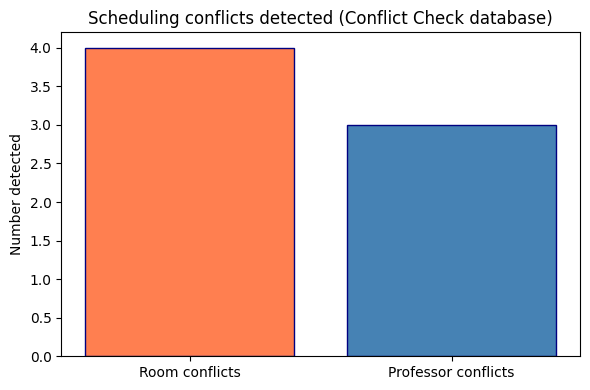

In [12]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('lous_list.db')
cur = conn.cursor()

# Insert temporary conflicts so the chart shows non-zero bars (demo only)
row = cur.execute('SELECT class_id, course_name, subject, meeting_time, professor_id, room_id FROM classes LIMIT 1').fetchone()
if row:
    cid, cname, subj, mt, pid, rid = row
    cur.execute("""INSERT INTO classes (course_name, subject, meeting_time, professor_id, room_id)
        VALUES ('Conflict Demo Room', 'XX', ?, ?, ?)""", (mt, pid, rid))
    cur.execute("""INSERT INTO classes (course_name, subject, meeting_time, professor_id, room_id)
        VALUES ('Conflict Demo Prof', 'XX', ?, ?, ?)""", (mt, pid, rid))
conn.commit()

# Count room conflicts: two different classes, same room, same time
q_room = """
SELECT COUNT(*) AS n FROM classes a
JOIN classes b ON a.room_id = b.room_id AND a.meeting_time = b.meeting_time AND a.class_id < b.class_id
"""
# Count professor conflicts: same professor, two different classes, same time
q_prof = """
SELECT COUNT(*) AS n FROM classes a
JOIN classes b ON a.professor_id = b.professor_id AND a.meeting_time = b.meeting_time AND a.class_id < b.class_id
"""
n_room = pd.read_sql_query(q_room, conn).iloc[0, 0]
n_prof = pd.read_sql_query(q_prof, conn).iloc[0, 0]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Room conflicts', 'Professor conflicts'], [n_room, n_prof], color=['coral', 'steelblue'], edgecolor='navy')
ax.set_ylabel('Number detected')
ax.set_title('Scheduling conflicts detected (Conflict Check database)')
plt.tight_layout()
plt.show()

# Remove demo rows so re-running doesn't accumulate
cur.execute("DELETE FROM classes WHERE course_name IN ('Conflict Demo Room', 'Conflict Demo Prof') AND subject = 'XX'")
conn.commit()
conn.close()


## 4.5 Apply in new context: Transportation

Confidence: 7

![4.5 Transportation ERD](Transportation_drawio.png)

**2. Two personas and example questions**

**Persona 1 — Student commuter**  
- *Which buses stop at the library, and when?*  
- *What’s the next vehicle on the North Line?*

**Persona 2 — Transit planner**  
- *How many vehicles are assigned to each route?*  
- *List all stops on Route 5 in order of sequence.*

## 4.6 Review: Definitions

Confidence: 8

**1. Abstraction Level**  
The degree of detail at which we view a system. The common levels are view/external, conceptual, logical, and physical. Higher abstraction hides implementation details; lower abstraction exposes them.

**2. Normal Forms**  
Stages of normalization (1NF, 2NF, 3NF, BCNF, etc.) that define how well a relational schema avoids redundancy and update anomalies. Each normal form adds rules: e.g., 1NF requires atomic values and a primary key; 2NF removes partial dependencies; 3NF removes transitive dependencies. Higher normal forms generally improve data integrity at the cost of more tables and joins.

**3. ERD**  
*Entity-Relationship Diagram.* A visual model of the domain showing *entities* (things we store, drawn as rectangles), *attributes* (properties of entities), and *relationships* (links between entities) with *cardinality* (one-to-one, one-to-many, many-to-many). Used in the conceptual/logical design phase before implementing the database.

**4. Schema**  
The structure of a database: the set of table names, column names, data types, primary keys, foreign keys, and constraints. The schema defines *what* can be stored and how tables relate; it does not include the actual data (which are the *instances*). Sometimes “schema” is used for the conceptual design and sometimes for the physical DDL (e.g., CREATE TABLE statements).

**5. Primary Key vs. Foreign Key**  
A *primary key* uniquely identifies each row in a table; it must be unique and non-null (often one column, e.g. `student_id`). A *foreign key* is a column (or set of columns) in one table that references the primary key of another table, enforcing referential integrity and defining relationships (e.g. `class_id` in Enrollments referencing Classes). A table has at most one primary key; it can have multiple foreign keys.

**6. SQL vs. MySQL**  
*SQL* (Structured Query Language) is the standard language for defining and querying relational databases (DDL, DML, DQL). *MySQL* is one specific *database management system* (DBMS) that implements SQL, along with its own extensions, storage engine, and tools. Other SQL implementations include PostgreSQL, SQLite, and SQL Server. So: SQL is the language; MySQL is a product that speaks that language.

**7. SQL vs. NoSQL**  
*SQL* (relational) databases store data in fixed-schema tables with rows and columns and use SQL for queries; they emphasize ACID transactions and structured data. *NoSQL* is a broad category of databases that often relax the rigid table structure: document (e.g. MongoDB), key-value, column-family, or graph stores. NoSQL is often chosen for scalability, flexible schemas, or specialized access patterns; SQL is chosen for complex queries and strong consistency.

**8. Entity vs. Attribute**  
An *entity* is a real-world object or concept we want to represent in the database (e.g. Student, Class, Professor); in the ERD it is the “thing” (often shown as a rectangle). An *attribute* is a property or characteristic of an entity (e.g. name, email, birth_date). Entities become tables; attributes become columns. So: entity = the noun/table; attribute = the descriptive column.

**9. Record**  
A single row in a table; one complete set of values for all columns of that table. For example, one student’s `student_id`, `first_name`, `last_name`, and `email` together form one record in the Students table. “Record” is often used interchangeably with *row* or *tuple* in relational terminology.

**10. Query**  
A request to the database to read or compute data (and sometimes to modify it). Typically written in SQL (e.g. SELECT ... FROM ... WHERE ...). A query describes *what* data you want (e.g. “all DS classes in Spring 2026”) rather than *how* to retrieve it; the DBMS translates the query into an execution plan.

**11. Relational Algebra**  
A formal, mathematical system for expressing operations on relations (tables). Core operations include selection (σ), projection (π), join (⋈), union (∪), difference (−), and rename (ρ). SQL is influenced by relational algebra; the DBMS often translates SQL into algebra-like operations for optimization and execution. It provides a precise way to reason about query correctness and equivalence.

**12. Cardinality**  
The number of related entities in a relationship. In ERDs we specify cardinality between two entities (e.g. one-to-one, one-to-many, many-to-many) using notation like crow’s foot. It answers: “For one instance of A, how many instances of B can exist, and vice versa?” Cardinality constraints guide schema design (e.g. whether to use a foreign key or a junction table).

**13. The many-to-many problem**  
When two entities relate in a many-to-many way (e.g. Students enroll in many Classes, and Classes have many Students), we cannot represent that with a single foreign key in either table—a foreign key points to exactly one row. So we cannot store “many” directly. The solution is to introduce a third table (a *junction* or *bridge* table) that has foreign keys to both entities and holds one row per association, effectively breaking the M:N into two one-to-many relationships.

**14. Junction/Bridge Table**  
A table used to implement a many-to-many relationship between two other tables. It typically has (at least) two foreign keys—one to each of the related tables—and often its own primary key and extra attributes (e.g. enrollment date, grade). Example: *Enrollments* with `student_id` → Students and `class_id` → Classes. Each row in the junction table represents one association (e.g. one student enrolled in one class).

## 4.7 Review: Multiple Choice

*Instructions: Select the best answer for each question. Do not show work.*

**4.7.1** In the ANSI/SPARC three-level architecture, the level that describes how data is actually stored on disk is the:  
**(D) Physical level**

**4.7.2** The external (view) level in database abstraction is primarily responsible for:  
**(C) Providing relevant information to different users**

**4.7.3** The cardinality constraint "one-to-many" in an ER diagram means:  
**(C) One instance of entity A can be associated with many instances of entity B, but each B is associated with at most one A**

**4.7.4** Which of the following is a common problem when a relational schema is not properly normalized?  
**(B) Update anomalies: changing one fact may require updating many rows**

**4.7.5** Choosing a natural key (e.g., email) over a surrogate key (e.g., auto-increment ID) can be problematic because:  
**(B) Natural keys may change or not be available at insert time, and updates can cascade**

**4.7.6** The primary purpose of creating an Entity-Relationship Diagram (ERD) before building a database is to:  
**(B) Visualize and plan the structure, relationships, and constraints before implementation**

**4.7.7** Database normalization is the process of:  
**(B) Organizing data to reduce redundancy and improve data integrity**

**4.7.8** Many-to-many (M:N) relationships require a junction table because:  
**(C) A foreign key in one table can only reference one row in another table**

**4.7.9** When designing a database that serves multiple user personas (e.g., students, professors, registrars), the best approach is to:  
**(B) Design the schema to store all necessary data and create different queries for each persona's needs**

**4.7.10** Which of the following is NOT a valid reason to add a new table to an existing database schema?  
**(C) To make a query run in fewer lines of code**

**4.7.11** This homework set is:  
**(D) Too long and Too hard**